In [1]:
import pystan
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
np.random.seed(101)

model_compile = True

In [2]:
# define stan model

# parameter 는 모델의 파라미터 / 분산은 0보다 크기 때문에 0 이상으로

model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(alpha + beta * x, sigma);
}
"""


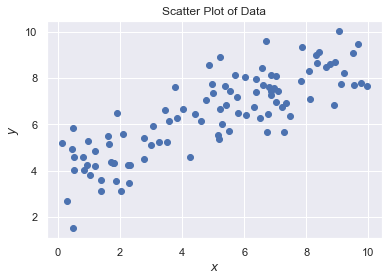

In [3]:
# generate data

alpha = 4.0
beta  = 0.5
sigma = 1.0

x = 10 * np.random.rand(100)
y = alpha + beta * x
y = np.random.normal(y, scale=sigma)

plt.scatter(x, y)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Scatter Plot of Data')
plt.show()

In [5]:
# put data in dictionary to deliver to stan model

data = {'N': len(x), 'x': x, 'y': y}

# compile stan model

if model_compile:
    # Compile the model
    stan_model = pystan.StanModel(model_code=model)
    # Save the model
    with open('regression_model.pkl', 'wb') as f:
        pickle.dump(sm, f)
else:
    stan_model = pickle.load(open('regression_model.pkl', 'rb'))


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cb4cc9c2a04d0e34d711077557307fb7 NOW.


gcc 오류 발생시

- export CC=x86_64-apple-darwin13.4.0-clang
- export CXX=x86_64-apple-darwin13.4.0-clang++

In [6]:
# Model Train

fit = stan_model.sampling(data=data, 
                          iter=1000, 
                          chains=4, 
                          warmup=500, 
                          thin=1, 
                          seed=101,
                          verbose=True)

print(fit)

Inference for Stan model: anon_model_cb4cc9c2a04d0e34d711077557307fb7.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   3.85  7.8e-3    0.2   3.43   3.71   3.84   3.99   4.25    689    1.0
beta    0.52  1.4e-3   0.04   0.45   0.49   0.52   0.54   0.59    695   1.01
sigma   1.02  2.2e-3   0.07   0.89   0.97   1.02   1.06   1.17   1055    1.0
lp__  -50.67    0.05    1.2 -53.74 -51.18 -50.38 -49.82 -49.27    660   1.01

Samples were drawn using NUTS at Sun Apr 19 19:27:37 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [7]:
# model summary

summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']

# Extracting traces
alpha = fit['alpha']
beta = fit['beta']
sigma = fit['sigma']
lp = fit['lp__']

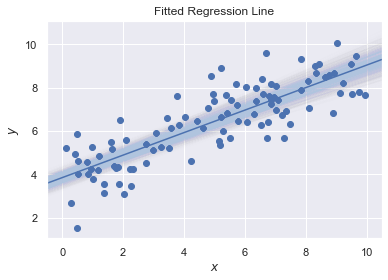

In [8]:
# Plotting regression line
x_min, x_max = -0.5, 10.5
x_plot = np.linspace(x_min, x_max, 100)

# Plot a subset of sampled regression lines
np.random.shuffle(alpha), np.random.shuffle(beta)
for i in range(1000):
  plt.plot(x_plot, 
           alpha[i] + beta[i] * x_plot, 
           color='lightsteelblue', 
           alpha=0.005)

# Plot mean regression line
plt.plot(x_plot, alpha_mean + beta_mean * x_plot)
plt.scatter(x, y)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Fitted Regression Line')
plt.xlim(x_min, x_max)
plt.show()

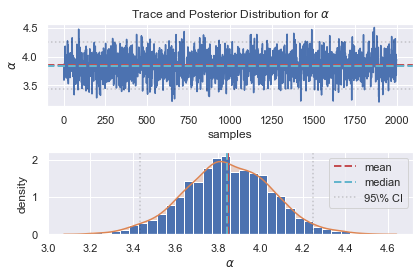

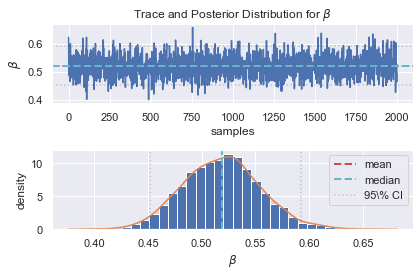

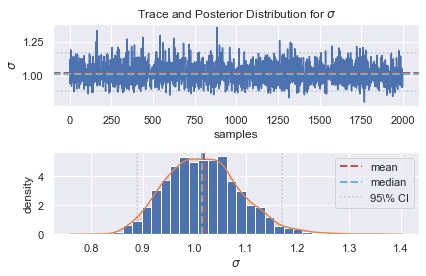

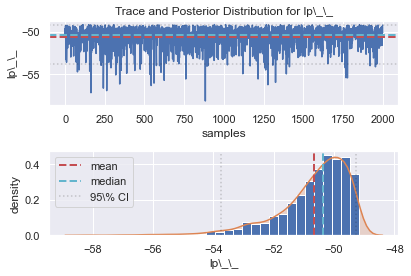

In [9]:
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""
    
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
    
    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    plt.title('Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label=r'95\% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
    
    plt.gcf().tight_layout()
    plt.legend()

plot_trace(alpha, r'$\alpha$') 
plt.show()
plot_trace(beta, r'$\beta$') 
plt.show()
plot_trace(sigma, r'$\sigma$') 
plt.show()
plot_trace(lp, r'lp\_\_') 
plt.show()

# Reference

- https://towardsdatascience.com/an-introduction-to-bayesian-inference-in-pystan-c27078e58d53
- https://github.com/mwestt/An-Introduction-to-Bayesian-Inference-in-PyStan/blob/master/PyStan_plotting.py